In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch import nn
from torch import optim
import torch.nn.functional as F
import symm4ml
import symm4ml.groups as groups
import symm4ml.vis as vis
import symm4ml.rep as rep
from pathlib import Path
import torch.optim.lr_scheduler as lr_scheduler
import os

SEED = 20240507
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = Path("data")
model_dir = Path("models")
pic_dir = Path("pictures")
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
if not os.path.exists(pic_dir):
    os.mkdir(pic_dir)

In [2]:
def rot_img(x, theta):
    """ Rotate 2D images
    Args:
        x : input images with shape [N, C, H, W]
        theta: angle
    Returns:
        rotated images
    """
    rot_mat = torch.FloatTensor([[np.cos(theta), -np.sin(theta), 0],
                                 [np.sin(theta), np.cos(theta), 0]])
    rot_mat = rot_mat.repeat(x.shape[0],1,1)
    grid = F.affine_grid(rot_mat.to(x.device), x.size(), align_corners=False).float()
    x = F.grid_sample(x, grid)
    return x.float()    

def op_img(x, op):
    affine_mat = torch.zeros(2, 3)
    affine_mat[:2, :2] = op
    affine_mat = affine_mat.repeat(x.shape[0],1,1)
    grid = F.affine_grid(affine_mat.to(x.device), x.size(), align_corners=False).float()
    x = F.grid_sample(x, grid)
    return x.float()

In [3]:
def train_model(model, inp, tgt, loss_fun, lr = 1e-3, n_epochs = 200, if_print=True, decay_step=200):
    optimizer = torch.optim.Adam(model.parameters(), lr)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    best_loss = 1e6
    for epoch in range(n_epochs):
        output = model(inp)
        loss = loss_fun(output.reshape(tgt.shape), tgt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         # print statistics
        if if_print:
            if epoch % max((n_epochs//10), 50) == 0:
                print("Epoch: {} | Loss: {:0.5f} ".format(epoch,  loss.item()))
        if epoch % decay_step == 1:
            scheduler.step()
    if output.device.type == 'cpu':
        return output.data.numpy()
    else:
        return output.cpu().data.numpy()

In [4]:
class Relaxed_GConv_Lifting(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 activation = True,
                 ):
        super(Relaxed_GConv_Lifting, self).__init__()
        E  = np.array([[ 1.,  0.], [ 0.,  1.]])
        R1 = np.array([[ 0., -1.], [ 1.,  0.]])
        R2 = -E   # np.array([[-1.,  0.], [ 0., -1.]])
        R3 = -R1  # np.array([[ 0.,  1.], [-1.,  0.]])
        S0 = np.array([[ 1.,  0.], [ 0., -1.]])
        S1 = np.array([[ 0.,  1.], [ 1.,  0.]])
        S2 = -S0
        S3 = -S1
        
        self.kernel_size = kernel_size
        self.activation = activation
        self.rep_2D = torch.from_numpy(np.stack([E, R1, R2, R3, S0, S1, S2, S3])).float()
        self.group_order = len(self.rep_2D)
        self.kernel = torch.nn.Parameter(torch.zeros(out_channels, in_channels,
                                                     kernel_size, kernel_size))
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        torch.nn.init.kaiming_uniform_(self.kernel.data, a=math.sqrt(5))
        self.relaxed_weights = torch.nn.Parameter(torch.ones(self.group_order,).float())
        affine_mat = torch.zeros(self.group_order, 2, 3)
        affine_mat[:, :2, :2] = self.rep_2D
        self.grids = F.affine_grid(affine_mat, [self.group_order, (out_channels*in_channels), kernel_size, kernel_size], 
                                  align_corners=False).float()
        
    def generate_filter_bank(self):
        """Creates rotated filter bank for 2D image convolution
        """
        (c_out, c_in, kh, kw) = self.kernel.shape
        filters = self.kernel.unsqueeze(0).repeat([self.group_order, 1, 1, 1, 1])
        filter_bank = F.grid_sample(filters.reshape(self.group_order, self.out_channels*self.in_channels, self.kernel_size, self.kernel_size), 
                                    self.grids.to(self.kernel.device), align_corners=False)
        return filter_bank.transpose(0,1).reshape(self.out_channels, self.group_order, self.in_channels, self.kernel_size, self.kernel_size)

    def forward(self, x):
        
        filter_bank = self.generate_filter_bank()
        relaxed_conv_weights = torch.einsum("a, oa... -> oa...", self.relaxed_weights, filter_bank)
        x = F.conv2d(
            input=x,
            weight=relaxed_conv_weights.reshape(
                self.out_channels * self.group_order,
                self.in_channels,
                self.kernel_size,
                self.kernel_size
            ),
            padding = (self.kernel_size-1)//2
        )
        x = x.view( x.shape[0], self.out_channels, self.group_order,
                    x.shape[-1], x.shape[-2]
        )
        if self.activation:
            return F.leaky_relu(x)
        else:
            return x

In [5]:
class Relaxed_GConv_Layer(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 activation = True,
                 ):
        super(Relaxed_GConv_Layer, self).__init__()

        self.kernel_size = kernel_size
        self.activation = activation
        E  = np.array([[ 1.,  0.], [ 0.,  1.]])
        R1 = np.array([[ 0., -1.], [ 1.,  0.]])
        R2 = -E   # np.array([[-1.,  0.], [ 0., -1.]])
        R3 = -R1  # np.array([[ 0.,  1.], [-1.,  0.]])
        S0 = np.array([[ 1.,  0.], [ 0., -1.]])
        S1 = np.array([[ 0.,  1.], [ 1.,  0.]])
        S2 = -S0
        S3 = -S1
        self.rep_2D = np.stack([E, R1, R2, R3, S0, S1, S2, S3])
        self.group_order = len(self.rep_2D)
        # Compute the multiplication tables given group elements
        self.mul_table = groups.make_multiplication_table(self.rep_2D)
        self.rep_2D = torch.from_numpy(self.rep_2D).float()
        self.inverses_indices = groups.inverses(self.mul_table)
        self.kernel = torch.nn.Parameter(torch.zeros(out_channels,
                                                     in_channels,
                                                     self.group_order,
                                                     kernel_size,
                                                     kernel_size))
        torch.nn.init.kaiming_uniform_(self.kernel.data, a=math.sqrt(5))
        self.relaxed_weights = torch.nn.Parameter(torch.ones(self.group_order).float())


    def generate_filter_bank(self, rep_2D, filters):
        """Creates rotated filter bank for 2D image convolution
        Input:
            rep_2D: torch.Tensor of shape [|G|, 2, 2] of the group representation as 2D rotations and mirrors
            filter: torch.Tensor of shape [channel_out, channel_in, rep_reg_filter, kernel_height, kernel_width]
        """
        (n_G, _, _) = rep_2D.shape
        (c_out, c_in, g_order, kh, kw) = filters.shape
        weights = filters.reshape(
            c_out*c_in, g_order, kh, kw
        )
        filter_banks = []
        for i in range(self.group_order):
            op = self.rep_2D[i]
            affine_mat = torch.zeros(2, 3)
            affine_mat[:2, :2] = op
            grid = F.affine_grid(affine_mat.repeat(c_out*c_in,1,1), 
                                 weights.shape, align_corners=False).float().to(filters.device)
            rotated_filter = F.grid_sample(weights, grid, align_corners=False)
            indices = torch.ones(self.group_order)
            for j in range(self.group_order):
                indices[j] = self.mul_table[i, self.inverses_indices[j]]
                # indices[j] = self.mul_table[self.inverses_indices[i], j]
            filter_banks.append(rotated_filter[:,indices.long()])
        return torch.stack(filter_banks).reshape(n_G, c_out, c_in, g_order, kh, kw).permute(1,0,2,3,4,5)

    def group_convolution(self, rep_2D, inputs, filters):
        """Performs group convolution of inputs and filters over the regular representation
        Input:
            rep_2D: torch.Tensor of shape [|G|, 2, 2] of the group representation as 2D rotations and mirrors
            input: torch.Tensor of shape [batch, channel_in, rep_reg_in, height, width]
            filter: torch.Tensor of shape [channel_out, channel_in, rep_reg_filter, kernel_height, kernel_width]
        Output:
            output: torch.Tensor of shape [batch, channel_out, rep_reg_out]
        """
        (k, i, j) = rep_2D.shape
        (z, c, i, h, w) = inputs.shape
        (c_out, c_in, n_G, kh, kw) = filters.shape
        filter_banks = self.generate_filter_bank(rep_2D, filters)
        relaxed_conv_weights = torch.einsum("a, oa... -> oa...", self.relaxed_weights, filter_banks)
        conv = F.conv2d(inputs.reshape(z, (c * i), h, w),
                        relaxed_conv_weights.reshape((n_G * c_out), (c_in * n_G), kh, kw),
                        padding=(self.kernel_size-1)//2)
        return conv.reshape(z, c_out, n_G, h, w)

    def forward(self, x):
        out = self.group_convolution(self.rep_2D, x, self.kernel)
        if self.activation:
            return F.leaky_relu(out)
        else:
            return out

class Image_GConvNet(torch.nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 hidden_dim,
                 num_gconvs 
                 ):
        super().__init__()

        self.gconvs = []
        self.gconvs.append(Relaxed_GConv_Lifting(in_channels, hidden_dim, kernel_size,  activation = True))
        for i in range(num_gconvs-2):
            self.gconvs.append(Relaxed_GConv_Layer(hidden_dim, hidden_dim, kernel_size, activation = True))
        self.gconvs.append(Relaxed_GConv_Layer(hidden_dim, out_channels, kernel_size, activation = False))
        self.gconvs = nn.Sequential(*self.gconvs)

    def forward(self, x):
        out = self.gconvs(x)
        out = torch.mean(out, dim = 2)
        return out

In [130]:
def count_model_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return {'total': total_params, 'trainable': trainable_params}
GConvNet = Image_GConvNet(in_channels = 1,
                          out_channels = 1,
                          kernel_size = 3,
                          hidden_dim = 64,
                          num_gconvs = 3).to(device)
print(count_model_parameters(GConvNet))

{'total': 300120, 'trainable': 300120}


# Equivariance Test

In [6]:
GConvNet = Image_GConvNet(in_channels = 1,
                          out_channels = 1,
                          kernel_size = 3,
                          hidden_dim = 8,
                          num_gconvs = 3)
rep_D4_2D = GConvNet.gconvs[0].rep_2D
inverses = GConvNet.gconvs[1].inverses_indices
data = torch.rand(size=(1, 1, 4, 4))
all_results = []
for i in range(8):
    op = rep_D4_2D[i] 
    r_data = op_img(data, op)
    ooo = GConvNet(data)
    r_ooo = GConvNet(r_data)
    all_results.append(torch.allclose( op_img(ooo, op), r_ooo ))
print(np.all(all_results))

/home/gridsan/ywang3/.conda/envs/ml/lib/python3.12/site-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


True


# Results

In [7]:
symmetry_dir = Path("symmetry")
if not os.path.exists(symmetry_dir):
    os.mkdir(symmetry_dir)

relaxed_weights_dir = symmetry_dir/"relaxed_weights_adjacent_double_well_2d"
if not os.path.exists(relaxed_weights_dir):
    os.mkdir(relaxed_weights_dir)

GConvNet = Image_GConvNet(in_channels = 1,
                          out_channels = 1,
                          kernel_size = 3,
                          hidden_dim = 32,
                          num_gconvs = 3).to(device)
resolution = 10
sample_dir = data_dir / "samples"
epochs = 601

all_weights = []
for i in range(1, 98):
    if i%5 == 0:
        print(i)
    samples = np.load(sample_dir/f"sample_{i}_double_well_2d.npy")
    H_1, edges_1 = np.histogramdd(samples, bins = (resolution, resolution), density=True)
    samples = np.load(sample_dir/f"sample_{i+1}_double_well_2d.npy")
    H_2, edges_2 = np.histogramdd(samples, bins = (resolution, resolution), density=True)

    H_1 = (H_1 - np.min(H_1)) / (np.max(H_1) - np.min(H_1))
    H_2 = (H_2 - np.min(H_2)) / (np.max(H_2) - np.min(H_2))

    H_1 = torch.from_numpy(H_1).to(device).reshape([1, 1, resolution, resolution]).float()
    H_2 = torch.from_numpy(H_2).to(device).reshape([1, 1, resolution, resolution]).float()

    out = train_model(GConvNet, 
                      H_1, 
                      H_2, 
                      loss_fun = nn.MSELoss(), n_epochs = epochs, if_print=False)
    relaxed_weights = torch.stack([GConvNet.gconvs[i].relaxed_weights.data.reshape(-1) for i in range(3)]).T.cpu().data.numpy()
    # np.save(relaxed_weights_dir/f"weights_{i}_{i+1}.npy", relaxed_weights)
    all_weights.append(relaxed_weights)

all_weights = np.stack(all_weights)

np.save(relaxed_weights_dir/f"weights_adjacent.npy", all_weights)


5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


In [32]:
symmetry_dir = Path("symmetry")
if not os.path.exists(symmetry_dir):
    os.mkdir(symmetry_dir)

relaxed_weights_dir = symmetry_dir/"relaxed_weights_original_double_well_2d"
if not os.path.exists(relaxed_weights_dir):
    os.mkdir(relaxed_weights_dir)

GConvNet = Image_GConvNet(in_channels = 1,
                          out_channels = 1,
                          kernel_size = 3,
                          hidden_dim = 32,
                          num_gconvs = 3).to(device)
resolution = 10
sample_dir = data_dir / "samples"
epochs = 601

all_weights_origin = []
for i in range(1, 99):
    if i%5 == 0:
        print(i)
    samples = np.load(sample_dir/f"sample_1_double_well_2d.npy")
    H_1, edges_1 = np.histogramdd(samples, bins = (resolution, resolution), density=True)
    samples = np.load(sample_dir/f"sample_{i}_double_well_2d.npy")
    H_2, edges_2 = np.histogramdd(samples, bins = (resolution, resolution), density=True)

    H_1 = (H_1 - np.min(H_1)) / (np.max(H_1) - np.min(H_1))
    H_2 = (H_2 - np.min(H_2)) / (np.max(H_2) - np.min(H_2))

    H_1 = torch.from_numpy(H_1).to(device).reshape([1, 1, resolution, resolution]).float()
    H_2 = torch.from_numpy(H_2).to(device).reshape([1, 1, resolution, resolution]).float()

    out = train_model(GConvNet, 
                      H_1, 
                      H_2, 
                      loss_fun = nn.MSELoss(), n_epochs = epochs, if_print=False)
    relaxed_weights = torch.stack([GConvNet.gconvs[i].relaxed_weights.data.reshape(-1) for i in range(3)]).T.cpu().data.numpy()
    # np.save(relaxed_weights_dir/f"weights_{i}_{i+1}.npy", relaxed_weights)
    all_weights_origin.append(relaxed_weights)

all_weights_origin = np.stack(all_weights_origin)

np.save(relaxed_weights_dir/f"weights_origin.npy", all_weights_origin)


5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


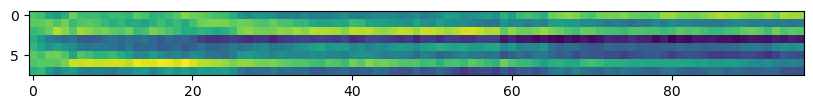

In [39]:
plt.figure(figsize=(10, 10))
plt.imshow(all_weights[:,:,0].T,)
pos_x = -1.4
label_list = ["E", "R1", "R2", "R3", "S0", "S1", "S2", "S3"]
plt.show()

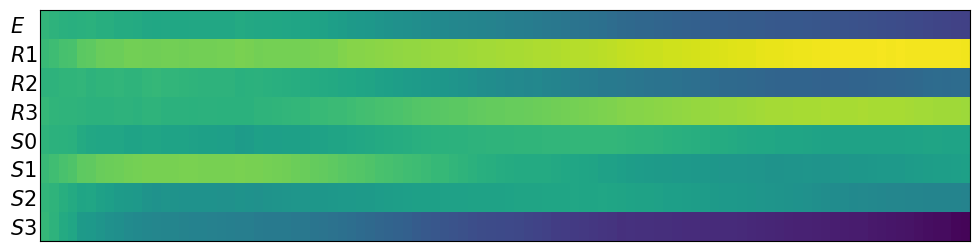

In [33]:
vf_weights = np.load("/home/gridsan/ywang3/Course_project/symmetry/relaxed_weights_vf/weights_vf.npy")
# plt.imshow(relaxed_weights_sr, cmap = 'Blues')
plt.figure(figsize=(12, 3))
plt.imshow(vf_weights[:,:,0].T, vmin=0.4, vmax=1.3,aspect='auto')
# plt.colorbar()
plt.yticks([])
plt.xticks([])
pos_x = -3.7
label_list = ["E", "R1", "R2", "R3", "S0", "S1", "S2", "S3"]
for i, label in enumerate(label_list):
    plt.text(pos_x, 0.3+i, f"${label}$", fontsize=15)
# plt.grid(color='black', linestyle='-', linewidth=2)
plt.savefig("pictures/weights_C2.png", transparent=True, dpi=1000)

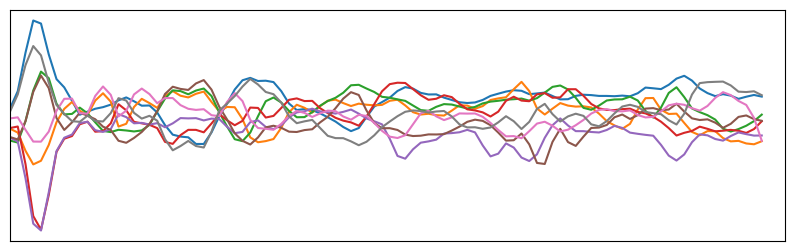

In [90]:



vf_weights_C2 = np.load("/home/gridsan/ywang3/Course_project/symmetry/relaxed_weights_vf/weights_vf.npy")
plt.figure(figsize=(10, 3))
for i in range(8):
    grad = np.gradient(vf_weights[:,i,0])
    N = 3
    ave_grad = np.convolve(grad, np.ones(N)/N, mode='valid')
    plt.plot(ave_grad, label=i)
    # plt.plot(np.gradient(np.gradient(vf_weights[:,i,0])), label=i)
plt.xticks([])
plt.yticks([])
plt.xlim([0, 100])
plt.savefig("pictures/C2_transitions_grad.png", transparent=True, dpi=1000)

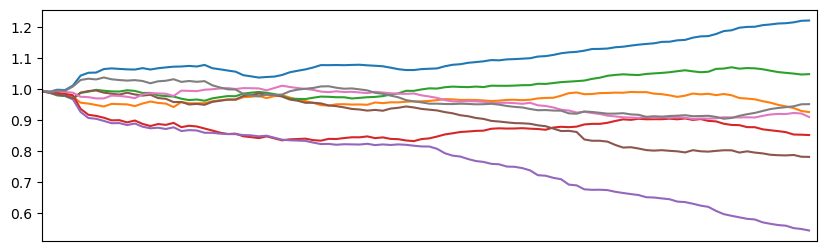

In [101]:
vf_weights_C2 = np.load("/home/gridsan/ywang3/Course_project/symmetry/relaxed_weights_vf/weights_vf.npy")
plt.figure(figsize=(10, 3))
for i in range(8):
    plt.plot((vf_weights[:,i,0]), label=i)
plt.xticks([])
# plt.yticks([])
plt.xlim([0, 100])
plt.savefig("pictures/C2_transitions.png", transparent=True, dpi=1000)

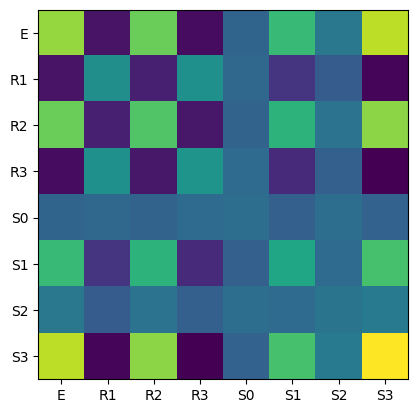

In [100]:
vf_weights_C2 = np.load("/home/gridsan/ywang3/Course_project/symmetry/relaxed_weights_vf/weights_vf.npy")
cov_m = np.cov(vf_weights_C2[:,:,0].T)
fig, ax = plt.subplots()
ax.imshow(cov_m)
x = np.arange(8)
ax.set_xticks(x)
ax.set_xticklabels(label_list)
ax.set_yticks(x)
ax.set_yticklabels(label_list)
plt.savefig("pictures/cov_m_C2.png", transparent=True)

In [49]:
label_list

['E', 'R1', 'R2', 'R3', 'S0', 'S1', 'S2', 'S3']

In [48]:
np.array(np.gradient(vf_weights[:,0,0])).shape

(100,)

# C4 group

In [16]:
GConvNet = Image_GConvNet(in_channels = 1,
                          out_channels = 1,
                          kernel_size = 3,
                          hidden_dim = 64,
                          num_gconvs = 3).to(device)
vf_dir = data_dir/"vector_field"

vf_999 = np.load(vf_dir/f"vf_999_C4_2d.npy").reshape(10, 10, 2)
vf_1 = np.load(vf_dir/f"vf_2_C4_2d.npy").reshape(10, 10, 2)

# vf_999_tensor = torch.from_numpy(np.sqrt(vf_999[:,:,1]**2+vf_999[:,:,0]**2)).float().reshape(1, 1, 10, 10).to(device)
vf_999_tensor = torch.from_numpy((vf_999[:,:,1]**2+vf_999[:,:,0]**2)).float().reshape(1, 1, 10, 10).to(device)

# vf_1_tensor = torch.from_numpy(np.sqrt(vf_1[:,:,1]**2+vf_1[:,:,0]**2)).float().reshape(1, 1, 10, 10).to(device)
vf_1_tensor = torch.from_numpy((vf_1[:,:,1]**2+vf_1[:,:,0]**2)).float().reshape(1, 1, 10, 10).to(device)

vf_999_tensor = (vf_999_tensor - torch.min(vf_999_tensor)) / (torch.max(vf_999_tensor) - torch.min(vf_999_tensor))
vf_1_tensor = (vf_1_tensor - torch.min(vf_1_tensor)) / (torch.max(vf_1_tensor) - torch.min(vf_1_tensor))

out = train_model(GConvNet, 
                  vf_1_tensor, 
                  vf_1_tensor, 
                  loss_fun = nn.MSELoss(), n_epochs = 301)

Epoch: 0 | Loss: 0.06139 
Epoch: 50 | Loss: 0.00015 
Epoch: 100 | Loss: 0.00005 
Epoch: 150 | Loss: 0.00003 
Epoch: 200 | Loss: 0.00002 
Epoch: 250 | Loss: 0.00001 
Epoch: 300 | Loss: 0.00001 


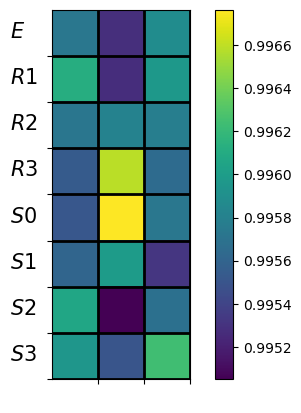

In [17]:
relaxed_weights_sr = torch.stack([GConvNet.gconvs[i].relaxed_weights.data.reshape(-1) for i in range(3)]).T.cpu().data.numpy()
# plt.imshow(relaxed_weights_sr, cmap = 'Blues')
plt.imshow(relaxed_weights_sr)
plt.colorbar()
pos_x = -1.4
label_list = ["E", "R1", "R2", "R3", "S0", "S1", "S2", "S3"]
for i, label in enumerate(label_list):
    plt.text(pos_x, 0.1+i, f"${label}$", fontsize=15)
plt.xticks(np.arange(0.5,3,1), color='w')
plt.yticks(np.arange(0.5,8,1), color='w')
plt.grid(color='black', linestyle='-', linewidth=2)
plt.show()

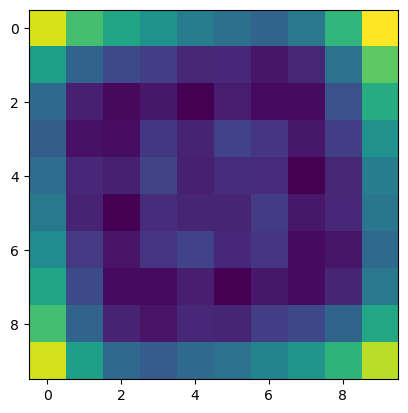

In [10]:
vf_dir = data_dir/"vector_field"

vf_999 = np.load(vf_dir/f"vf_999_C4_2d.npy").reshape(10, 10, 2)
vf_1 = np.load(vf_dir/f"vf_200_C4_2d.npy").reshape(10, 10, 2)
plt.figure()
plt.imshow(vf_1[:,:,0]**2 + vf_1[:,:,1]**2)
plt.show()

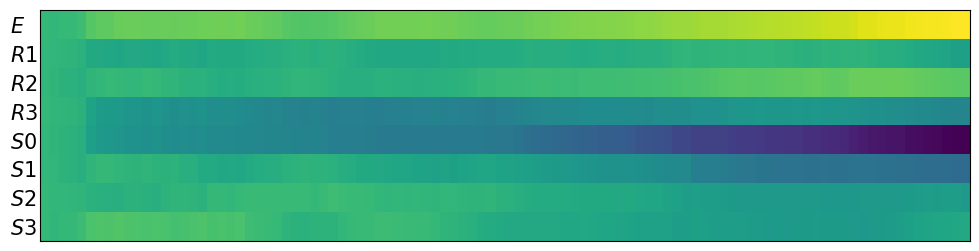

In [96]:
vf_weights = np.load("/home/gridsan/ywang3/Course_project/symmetry/relaxed_weights_vf_C4/weights_vf_C4.npy")
# plt.imshow(relaxed_weights_sr, cmap = 'Blues')
plt.figure(figsize=(12, 3))
plt.imshow(vf_weights[:,:,0].T, aspect='auto')
# plt.colorbar()
plt.yticks([])
plt.xticks([])
pos_x = -3.7
label_list = ["E", "R1", "R2", "R3", "S0", "S1", "S2", "S3"]
for i, label in enumerate(label_list):
    plt.text(pos_x, 0.3+i, f"${label}$", fontsize=15)
# plt.grid(color='black', linestyle='-', linewidth=2)
plt.savefig("pictures/weights_C4.png", transparent=True, dpi=1000)

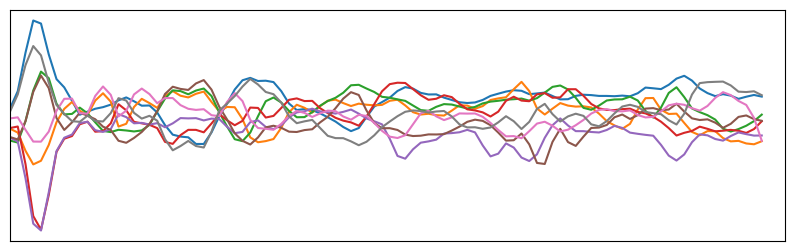

In [97]:
vf_weights_C4 = np.load("/home/gridsan/ywang3/Course_project/symmetry/relaxed_weights_vf_C4/weights_vf_C4.npy")
plt.figure(figsize=(10, 3))
for i in range(8):
    grad = np.gradient(vf_weights_C4[:,i,0])
    N = 3
    ave_grad = np.convolve(grad, np.ones(N)/N, mode='valid')
    plt.plot(ave_grad, label=i)
    # plt.plot(np.gradient(np.gradient(vf_weights[:,i,0])), label=i)
plt.xticks([])
plt.yticks([])
plt.xlim([0, 100])
plt.savefig("pictures/C4_transitions_grad.png", transparent=True, dpi=1000)

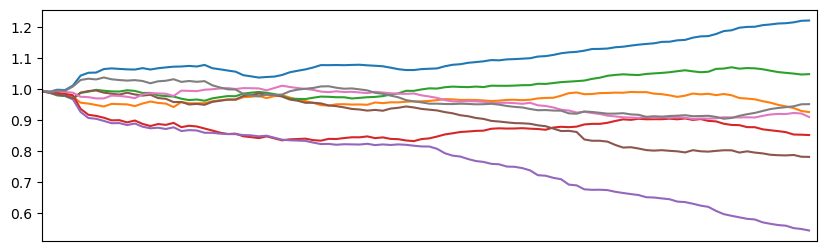

In [107]:
vf_weights_C4 = np.load("/home/gridsan/ywang3/Course_project/symmetry/relaxed_weights_vf_C4/weights_vf_C4.npy")
plt.figure(figsize=(10, 3))
for i in range(8):
    plt.plot((vf_weights_C4[:,i,0]), label=i)
plt.xticks([])
# plt.yticks([])

plt.xlim([0, 100])
plt.savefig("pictures/C4_transitions.png", transparent=True, dpi=1000)

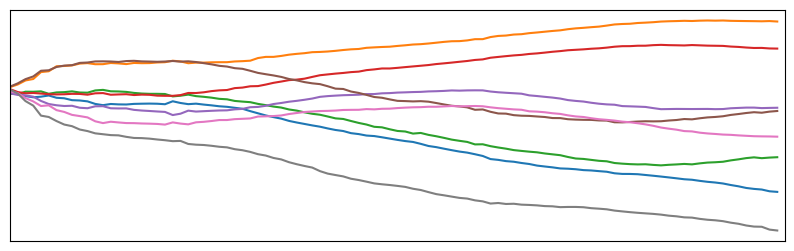

In [112]:
plt.figure(figsize=(10, 3))
for i in range(8):
    plt.plot((vf_weights_C2[:,i,0]), label=i)
plt.xticks([])
plt.yticks([])

plt.xlim([0, 100])
plt.savefig("pictures/C2_transitions.png", transparent=True, dpi=1000)

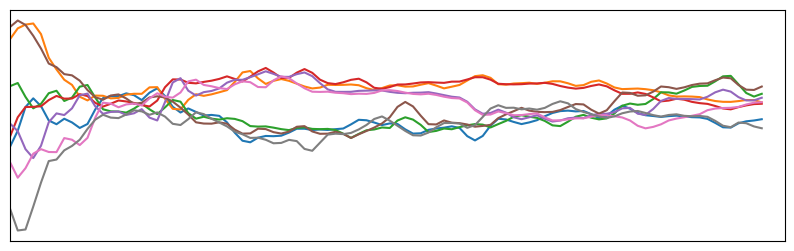

In [111]:
plt.figure(figsize=(10, 3))
for i in range(8):
    grad = np.gradient(vf_weights_C2[:,i,0])
    N = 3
    ave_grad = np.convolve(grad, np.ones(N)/N, mode='valid')
    plt.plot(ave_grad, label=i)
    # plt.plot(np.gradient(np.gradient(vf_weights[:,i,0])), label=i)
plt.xticks([])
plt.yticks([])
plt.xlim([0, 100])
plt.savefig("pictures/C2_transitions_grad.png", transparent=True, dpi=1000)

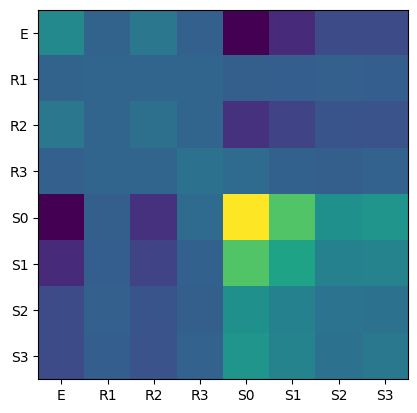

In [113]:
cov_m = np.cov(vf_weights_C4[:,:,0].T)
fig, ax = plt.subplots()
ax.imshow(cov_m)
x = np.arange(8)
ax.set_xticks(x)
ax.set_xticklabels(label_list)
ax.set_yticks(x)
ax.set_yticklabels(label_list)
plt.savefig("pictures/cov_m_C4.png", transparent=True)